### 4.3 A Gaussian model of height

In [20]:
import pandas as pd
import numpy as np
import arviz as az  #ArviZ: Exploratory analysis of Bayesian models
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform

##### load the data and create a subset (code 4.10)

In [11]:
df = pd.read_csv('../Data/Howell1.csv', sep=';', header=0)
df.head()
df2 = df[df.age >=18]

In [12]:
#df2.sort_values('age').head()

##### kde of height

Text(0.5, 0, 'Height')

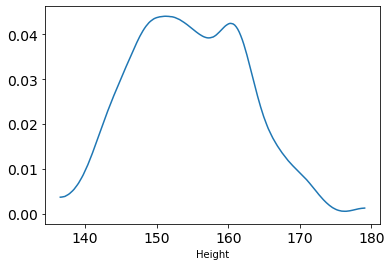

In [28]:
az.plot_kde(df2.height)
plt.xlabel('Height')

##### code 4.11

In [17]:
x = np.linspace(100, 250, num=1000)
y = norm.pdf(x, loc=178, scale=20)

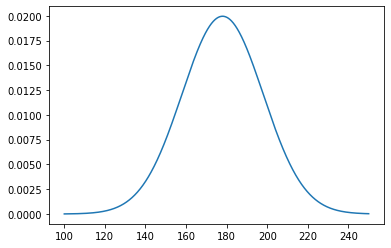

In [18]:
plt.plot(x, y)
plt.show()

##### code 4.12

In [23]:
x = np.linspace(-10, 60, num=100)
y = uniform.pdf(x, loc=0, scale=50)

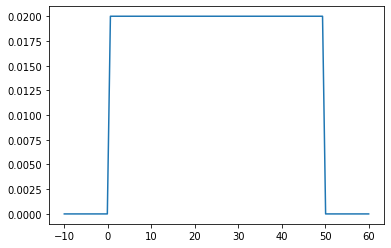

In [24]:
plt.plot(x, y)
plt.show()

##### code 4.13

In [25]:
sample_mu = norm.rvs(loc=178, scale=20, size=int(1e4), random_state=110)
sample_sigma = uniform.rvs(loc=0, scale=50, size=int(1e4), random_state=110)

In [27]:
prior_h = norm.rvs(loc=sample_mu, scale=sample_sigma, size=int(1e4), random_state=110)
# note: It is not clear whether the code above is accurate; that is, it is not clear to me what happens afer passing a  
# vector for loc and a vector for scale. 

Text(0.5, 0, 'Height')

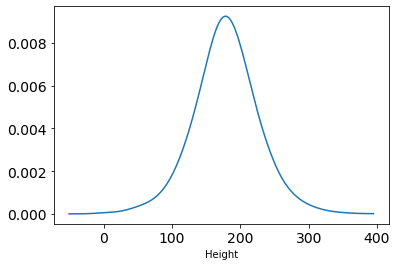

In [29]:
az.plot_kde(prior_h)
plt.xlabel('prior_h')
